In [3]:
class my_GMM:
    def __init__(self, k, max_iter=50, method = 'random_mean_var_pi', tol=1e-4):
        self.k = k
        self.method = method
        self.max_iter = max_iter
        self.tol = tol
    
    def init_all(self, X):
        if self.method == 'random_mean_var_pi': # generating K random means, covar's and pi's
            self.means = X[np.random.choice(X.shape[0], self.k)]
            self.covs = []
            for i in range(self.k):
                covX = np.random.rand(X.shape[1], X.shape[1])
                self.covs.append(np.dot(covX, covX.T))  #generating semi-positive definite matrix
            
            self.pis = np.random.rand(self.k)
            self.pis /= np.sum(self.pis)
#             print(self.means, self.covs, self.pis)
    
        if self.method == 'random_mean': # generate K random means
            self.means = X[np.random.choice(X.shape[0], self.k)]
            self.covs = []
            for i in range(self.k):
                self.covs.append(np.cov(X.T)) 

            self.pis = np.ones(self.k) / self.k
#             print(self.means, self.covs, self.pis)
        
        if self.method == 'random_divide': # divide data into K clusters randomly
            X_splitted = np.array_split(X, self.k)
            self.means = [np.mean(x, axis=0) for x in X_splitted]
            self.covs = [np.cov(x.T) for x in X_splitted]
            self.pis = [len(x)/len(X) for x in X_splitted]
#             print(self.means, self.covs, self.pis)

        if self.method == 'k-means': # generate initial points by KMeans algo
            self.kmeans = KMeans(n_clusters=self.k, copy_x=True)
            self.kmeans.fit(X)
            self.y_kmeans = self.kmeans.predict(X)

            X_splitted = []
            for i in range(self.k):
                X_splitted.append(X[self.y_kmeans == i])

            self.means = [np.mean(x, axis=0) for x in X_splitted]
            self.covs = [np.cov(x.T) for x in X_splitted]
            self.pis = [len(x)/len(X) for x in X_splitted]
#             print(self.means, self.covs, self.pis)
            
        return self.means, self.covs, self.pis
            

    def pdf(self, x, mean, cov):
        return 1/np.sqrt(2 * np.pi * np.linalg.det(cov)) * np.exp(-1/2 * np.dot(x - mean, np.dot(np.linalg.inv(cov), x-mean)))
    
    def expectation(self, X, means, covs, pis):
        self.gamma_mtrx = np.zeros((X.shape[0], self.k))
        for i in range(len(X)):
            self.denom = []
            for j in range(self.k):
                self.gamma_mtrx[i, j] = pis[j] * self.pdf(X[i], means[j], covs[j])
                self.denom.append(self.gamma_mtrx[i, j])
            self.gamma_mtrx[i] /= np.sum(self.denom, axis = 0)
        return self.gamma_mtrx
    
    def maximization(self, X, gammas):
        self.Nk = np.sum(gammas, axis = 0)
        self.pis = self.Nk / len(X)
    
        self.means = []
        self.covs = []

        for i in range(self.k):
            self.means.append(np.dot(gammas[:, i], X) / self.Nk[i])
            self.covs.append(np.dot(gammas[:, i] * (X - self.means[i]).T, (X - self.means[i]))/ self.Nk[i])
        return np.array(self.means), np.array(self.covs), np.array(self.pis)

    def loss(self, X, means, covs, pis):
        self.loss_matrix = []
        for i in range(len(X)):
            self.loss_row = []
            for j in range(self.k):
                self.loss_row.append(pis[j] * self.pdf(X[i], means[j], covs[j]))
            self.loss_matrix.append(np.log(np.sum(self.loss_row)))
        return np.sum(self.loss_matrix)

    def fit(self, X):
        self.mean_arr, self.cov_arr, self.pi_arr = self.init_all(X)
        self.log_loss = self.loss(X, self.mean_arr, self.cov_arr, self.pi_arr)

        for _ in range(self.max_iter):
            self.gamma_mtrx = self.expectation(X, self.mean_arr, self.cov_arr, self.pi_arr)
                
            mean_arr, cov_arr, pi_arr = self.maximization(X, self.gamma_mtrx)

            log_loss = self.loss(X, mean_arr, cov_arr, pi_arr)
#             print(log_loss)

            if np.abs(log_loss - self.log_loss) <= self.tol or (np.abs(mean_arr - self.mean_arr).all()<=self.tol   
                                                                and np.abs(pi_arr - self.pi_arr).all()<=self.tol):
                
#                 print(np.abs(log_loss - self.log_loss))
                break
            
            self.log_loss = log_loss
            self.mean_arr = mean_arr
            self.cov_arr = cov_arr
            self.pi_arr = pi_arr
        print("number of iterations:", _ + 1)
        pass

    def predict(self, X): 
        return np.argmax(self.expectation(X, self.mean_arr, self.cov_arr, self.pi_arr), axis = 1)
    
    def predict_proba(self, X):
        return self.expectation(X, self.mean_arr, self.cov_arr, self.pi_arr)

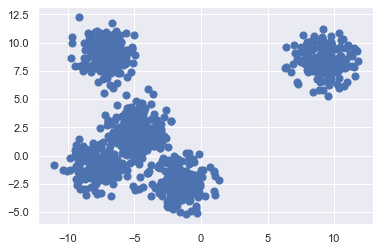

In [1]:
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

k = 5

from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=1000, centers=k,
                       cluster_std=1.1)

plt.scatter(X[:, 0], X[:, 1], s=50, cmap='viridis')

number of iterations: 20


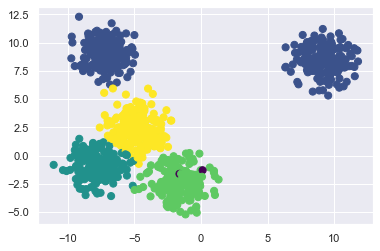

In [12]:
my_gmm = my_GMM(k)
my_gmm.fit(X)

my_y = my_gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=my_y, s=50, cmap='viridis')

number of iterations: 12


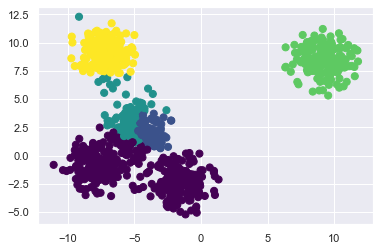

In [14]:
my_gmm = my_GMM(k,method='random_mean')
my_gmm.fit(X)

my_y = my_gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=my_y, s=50, cmap='viridis')

number of iterations: 29


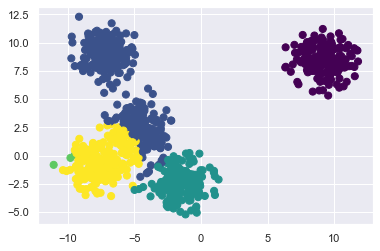

In [13]:
my_gmm = my_GMM(k,method='random_divide')
my_gmm.fit(X)

my_y = my_gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=my_y, s=50, cmap='viridis')

number of iterations: 2


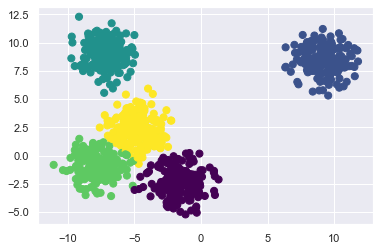

In [10]:
my_gmm = my_GMM(k,method='k-means')
my_gmm.fit(X)

my_y = my_gmm.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=my_y, s=50, cmap='viridis')

In [54]:
my_y_probas = my_gmm.predict_proba(X)
my_y_probas

array([[2.09672509e-12, 4.60621467e-10, 1.59046454e-47, 8.73224389e-02,
        9.12677561e-01],
       [9.99999999e-01, 1.32344758e-23, 1.67483987e-55, 6.92285559e-10,
        3.99503375e-15],
       [2.67451526e-09, 1.88447411e-37, 1.20629149e-22, 9.99999997e-01,
        2.71527394e-10],
       ...,
       [5.20663292e-10, 8.00706939e-33, 7.84184233e-24, 9.99999568e-01,
        4.31662508e-07],
       [2.93061726e-18, 3.59343767e-14, 5.62048037e-42, 2.15060612e-01,
        7.84939388e-01],
       [1.00000000e+00, 1.33097394e-33, 6.58660945e-59, 3.49022464e-13,
        1.66276469e-24]])

In [ ]:
# insights: 

# 'random mean, covs, pis': sometimes gets noninvertible cov matrixes, hence should be reevaluated 
# until good cov matrixes are found. however, if so - the results are rather good

# 'random mean': takes a lot of steps, the output highly depends on the initial choice and stds of data

# 'random divide': is rather fast, but the output highly depends on the initial choice and stds of data

# 'k-means': super! fast and accurate


In [ ]:
# comparing with the sklearn ones

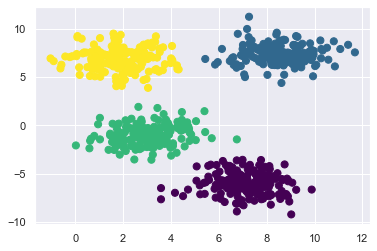

In [6]:
from sklearn import mixture

g = mixture.GaussianMixture(n_components=4)
g.fit(X)
g.predict_proba(X)
y_gmm= g.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_gmm, s=50, cmap='viridis')